## INTRODUCTION

The dataset consists of user data collected from transitions through web pages. The aim is to classify one user among all the users.

### IMPORTS

In [297]:
!pip install pyarrow
!pip install imbalanced-learn
!pip install lightgbm
!pip install xgboost
!pip install hyperopt

^C



In [298]:
import pandas as pd
import numpy as np
import scipy.stats
import pyarrow.parquet as pq

import matplotlib.pyplot as plt
import seaborn as sns

import os

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import make_pipeline

from sklearn.feature_extraction import FeatureHasher
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import warnings 
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (5, 5)

### FUNCTIONS AND COMMONLY USED CONSTANTS

In [299]:
def preproc(df):
    return (
        df.assign(            
            # session duration
            duration = lambda x: x.filter(like='dt_').apply(lambda row: row.sum(), axis=1),
            
            # proportion of missing pages
            missing_pages = lambda x: x.filter(like='webpage').isna().sum(axis=1) / 10,
            
            # avg duration per visited page
            avg_duration = lambda x: 
                x.filter(like='duration').apply(lambda x: x.sum(), axis=1) / (10 - x.missing_pages),
            
            # proportion of unique pages in session
            unique_pages = lambda x: 
                x.filter(like='webpage').apply(lambda row: row.nunique(), axis=1) / (10 - x.missing_pages),
            
            # most visited page
            mode_page = lambda x: x.filter(like='webpage').apply(lambda row: row.mode().iat[0], axis=1),
            
            # year of a session
            year = lambda x: x.filter(like='time').apply(lambda x: x.dt.year).mean(axis=1),
            
            # month of a session
            avg_month = lambda x: x.filter(like='time').apply(lambda x: x.dt.month).mean(axis=1),
            
            # day of a session
            avg_day = lambda x: x.filter(like='time').apply(lambda x: x.dt.day).mean(axis=1),
           
            # avg hour of day in a session
            avg_hour = lambda x: x.filter(like='time').apply(lambda x: x.dt.hour).mean(axis=1),
            
            # avg day of week in a session
            avg_weekday = lambda x: x.filter(like='time').apply(lambda x: x.dt.dayofweek).mean(axis=1),
            
            # creating cyclical features
            hour_sin = lambda x: x.filter(like='avg_hour').apply(lambda x: np.sin(x*(2.*np.pi/24))),
            hour_cos = lambda x: x.filter(like='avg_hour').apply(lambda x: np.cos(x*(2.*np.pi/24))),
            
            day_sin = lambda x: x.filter(like='avg_day').apply(lambda x: np.sin(x*(2.*np.pi/30))),
            day_cos = lambda x: x.filter(like='avg_day').apply(lambda x: np.cos(x*(2.*np.pi/30))),
            
            weekday_sin = lambda x: x.filter(like='avg_weekday').apply(lambda x: np.sin(x*(2.*np.pi/7))),
            weekday_cos = lambda x: x.filter(like='avg_weekday').apply(lambda x: np.cos(x*(2.*np.pi/7))),
            
            month_sin = lambda x: x.filter(like='avg_month').apply(lambda x: np.sin(x*(2.*np.pi/12))),
            month_cos = lambda x: x.filter(like='avg_month').apply(lambda x: np.cos(x*(2.*np.pi/12))),
            
        )
       
        # drop time columns
        .drop(columns=[f'time{i+1}' for i in range(10)])
        
        # fill missing pages with -200
        .fillna(-200)
    )

## DATASET PREPARATION

In [300]:
table_websites = pq.read_table(r'C:\Users\1\Desktop\id_map.parquet')

In [301]:
table_websites = table_websites.to_pandas()


In [302]:
df_train = pd.read_csv(r'C:\Users\1\Desktop\HW_Classification\train.csv', index_col=0)
df_test = pd.read_csv(r'C:\Users\1\Desktop\HW_Classification\test.csv', index_col=0)

In [303]:
time_cols = [col for col in df_train.columns if 'time' in col]
webpage_cols = [col for col in df_train.columns if 'webpage' in col]
target = df_train.target

In [304]:
for i in time_cols:
    df_train[i] = pd.to_datetime(df_train[i], format='%Y-%m-%d %H:%M:%S')
    df_test[i] = pd.to_datetime(df_test[i], format='%Y-%m-%d %H:%M:%S')

In [305]:
for i in range(1,10):
    df_train['dt_'+str(i)] = (df_train['time'+str(i+1)] - df_train['time'+str(i)]).dt.seconds
    df_test['dt_'+str(i)] = (df_test['time'+str(i+1)] - df_test['time'+str(i)]).dt.seconds
    
time_delta_cols = [col for col in df_train.columns if 'dt_' in col]

In [306]:
df_train_proc = preproc(df_train)

In [307]:
df_test_proc = preproc(df_test)

In [308]:
df_train_proc.head()

,webpage1,webpage2,webpage3,webpage4,webpage5,webpage6,webpage7,webpage8,webpage9,webpage10,...,avg_hour,avg_weekday,hour_sin,hour_cos,day_sin,day_cos,weekday_sin,weekday_cos,month_sin,month_cos
session_id,,,,,,,,,,,,,,,,,,,,,
0,9486,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,...,5.0,2.0,9.659258e-01,2.588190e-01,-0.866025,-0.500000,0.974928,-0.222521,8.660254e-01,0.5
1,11722,12385.0,50163.0,12385.0,12398.0,50150.0,50163.0,50150.0,19860.0,19886.0,...,7.0,4.0,9.659258e-01,-2.588190e-01,-0.994522,-0.104528,-0.433884,-0.900969,8.660254e-01,0.5
2,192149,659.0,192136.0,192149.0,633.0,659.0,192136.0,192136.0,192136.0,192136.0,...,12.0,6.0,1.224647e-16,-1.000000e+00,-0.207912,-0.978148,-0.781831,0.623490,-2.449294e-16,1.0
3,10591,451.0,77580.0,227821.0,633.0,425.0,10591.0,227834.0,227834.0,227834.0,...,12.0,2.0,1.224647e-16,-1.000000e+00,0.406737,-0.913545,0.974928,-0.222521,8.660254e-01,0.5
4,438,425.0,529.0,65685.0,187638.0,451.0,425.0,65685.0,187625.0,187625.0,...,6.0,3.0,1.000000e+00,6.123234e-17,0.587785,-0.809017,0.433884,-0.900969,8.660254e-01,-0.5


In [309]:
corr = df_train_proc.corr()

<AxesSubplot:>

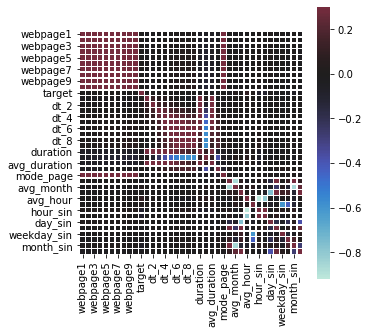

In [310]:
sns.heatmap(corr, vmax=.3, center=0, square=True, linewidths=0.5)

## MODEL

In [311]:
X = df_train_proc.drop('target', axis=1)
y = target

- **Undersampling**

In [313]:
undersample = RandomUnderSampler(sampling_strategy=0.5)

In [314]:
X_under, y_under = undersample.fit_resample(X, y)

- **Classifier**

In [315]:
clf = XGBClassifier()

### HYPERPARAMETERS TUNING

In [316]:
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size = 0.3, random_state = 0, stratify = y_under)

In [317]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [318]:
def objective(space):
    clf=XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [(X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    roc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    print ("SCORE:", roc)
    return {'loss': -roc, 'status': STATUS_OK }

In [319]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                                                                                 
0.8967090618253408                                                                                                     
SCORE:                                                                                                                 
0.6091949394274976                                                                                                     
SCORE:                                                                                                                 
0.740836940836941                                                                                                      
SCORE:                                                                                                                 
0.922310592078034                                                                                                      
SCORE:                                  

In [320]:
print(best_hyperparams)

{'colsample_bytree': 0.5456494837348737, 'gamma': 1.2170245512153282, 'max_depth': 12.0, 'min_child_weight': 10.0, 'reg_alpha': 40.0, 'reg_lambda': 0.9084191898623541}


In [327]:
best_hyperparams["max_depth"] = best_hyperparams["max_depth"].astype('int32')

In [328]:
clf = XGBClassifier(**best_hyperparams)

In [329]:
clf.fit(X_under,y_under)

[17:01:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5456494837348737,
              gamma=1.2170245512153282, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=12, min_child_weight=10.0,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=4, num_parallel_tree=1, random_state=0, reg_alpha=40.0,
              reg_lambda=0.9084191898623541, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [330]:
y_pred = clf.predict(df_test_proc)

## SUBMISSION

In [331]:
def save_submission(pred):
    pd.Series(
        pred, name='target', index=pd.Index(range(len(pred)), name='session_id')
    ).to_csv('submission_Ilia_Dotsenko.csv')

In [332]:
save_submission(y_pred)